In [ ]:
import jax
import jax.numpy as jnp
from jax import random, vmap, grad, jit
from jax.scipy.special import logsumexp
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. Target Energy Function (Unnormalized)
# ==========================================
# We define a Mixture of Gaussians as our target density p(x).
# Energy E(x) = -log p_tilde(x)

def target_log_prob(x):
    """
    Log-probability of a 2D Gaussian Mixture (unnormalized is fine for SVGD,
    but for validation we use a normalized one here to check results).
    """
    # Means of the mixture components
    means = jnp.array([[-2.0, -2.0], [2.0, 2.0]])
    # Log weights
    logits = jnp.array([0.0, 0.0]) # Equal weights

    # Calculate log-prob for each component
    # -0.5 * ||x - mu||^2 - log(Z)
    # Ignoring constants for the kernel, but crucial for exact log_prob check
    x_flatten = x.reshape(-1, 2)

    def get_component_log_prob(mu):
        diff = x_flatten - mu
        return -0.5 * jnp.sum(diff**2, axis=1) - jnp.log(2 * jnp.pi)

    # vmap over means
    component_log_probs = vmap(get_component_log_prob)(means) # [2, N]

    # Mixture log prob: log(sum(exp(log_w + log_p)))
    log_probs = logsumexp(component_log_probs + logits[:, None], axis=0) - logsumexp(logits)
    return log_probs.reshape(x.shape[:-1])

def energy_fn(x):
    return -target_log_prob(x)

# ==========================================
# 2. Kernel Functions for SVGD
# ==========================================

def rbf_kernel(x, y, h=-1):
    """
    RBF Kernel k(x, y) = exp(-||x-y||^2 / h)
    If h is -1, use median heuristic.
    """
    diff = x - y
    sq_dist = jnp.sum(diff**2)

    # In a real SVGD step, 'h' is usually computed globally based on pairwise distances.
    # For simplicity in 'grad' computation, we assume h is fixed or passed in.
    return jnp.exp(-sq_dist / h)

def get_median_h(X):
    """Compute bandwidth h using median heuristic."""
    N = X.shape[0]
    # Subsample if N is large to save memory
    X_sub = X[:1000]
    diff = X_sub[:, None, :] - X_sub[None, :, :]
    sq_dists = jnp.sum(diff**2, axis=-1)
    median_sq_dist = jnp.median(sq_dists)
    return median_sq_dist / jnp.log(N) + 1e-6 # Stability

# ==========================================
# 3. SVGD Update Logic
# ==========================================

def svgd_gradient_factory(score_fn_for_svgd):
    @jit
    def svgd_gradient_inner(X_current, h_val):
        """
        Computes the SVGD driving force phi(x).
        phi(x_i) = 1/N sum_j [ k(x_j, x_i) * score(x_j) + grad_x_j k(x_j, x_i) ]
        """
        N = X_current.shape[0]

        # 1. Score function: grad_x log p(x) = -grad_x E(x)
        scores = score_fn_for_svgd(X_current) # [N, D]

        # Pairwise distances for kernel
        diff = X_current[:, None, :] - X_current[None, :, :] # [N, N, D]
        sq_dists = jnp.sum(diff**2, axis=-1) # [N, N]

        # Kernel matrix
        K = jnp.exp(-sq_dists / h_val) # [N, N]

        # Gradient of kernel wrt first argument x_j: grad_x_j k(x_j, x_i)
        # For RBF: grad_x_j k = k * (-2/h * (x_j - x_i))
        grad_K = K[:, :, None] * (-2.0 / h_val * diff) # [N, N, D]

        # SVGD update rule
        # phi[i] = mean_j ( K[j,i] * scores[j] + grad_K[j,i] )
        phi = (jnp.matmul(K.T, scores) + jnp.sum(grad_K, axis=0)) / N

        return phi
    return svgd_gradient_inner

# ==========================================
# 4. Entropy Estimation: k-NN
# ==========================================

def entropy_knn(X, k=5):
    """
    Kozachenko-Leonenko Entropy Estimator.
    H(X) approx psi(N) - psi(k) + d/N * sum(log(R_i)) + log(Cd)
    where R_i is distance to k-th neighbor.
    """
    N, D = X.shape

    # Compute pairwise squared distances
    diff = X[:, None, :] - X[None, :, :]
    sq_dists = jnp.sum(diff**2, axis=-1)

    # Sort to find k-th neighbor
    # We ignore the 0-th (which is the point itself)
    sq_dists_sorted = jnp.sort(sq_dists, axis=1)

    # Distance to k-th neighbor
    # index k because 0 is self
    r_k = jnp.sqrt(sq_dists_sorted[:, k])

    # Volume of unit ball in D dimensions
    # V_d = pi^(d/2) / Gamma(d/2 + 1)
    log_vd = (D/2.0) * jnp.log(jnp.pi) - jax.scipy.special.gammaln(D/2.0 + 1.0)

    euler_psi = jax.scipy.special.digamma

    # Entropy estimate
    term1 = euler_psi(N) - euler_psi(k)
    term2 = D * jnp.mean(jnp.log(r_k + 1e-10)) # Add epsilon for stability
    return term1 + log_vd + term2

# ==========================================
# 5. Entropy Estimation: Flow Tracking (Log-Det)
# ==========================================

def update_log_prob(X, phi, epsilon, current_log_prob):
    """
    Updates the log probability density of the particles.
    log q_{t+1}(x') = log q_t(x) - log det(I + eps * J_phi)
                    approx log q_t(x) - eps * Tr(J_phi)
    """
    # This function is not used in run_svgd and is kept for completeness
    # as it was part of the original cell. Its implementation requires
    # a more complex Jacobian calculation for the whole phi field.

    def single_particle_phi(x_i, X_batch, h_val, score_fn):
        N = X_batch.shape[0]
        diff = X_batch - x_i
        sq_dists = jnp.sum(diff**2, axis=1)
        K = jnp.exp(-sq_dists / h_val)

        scores_batch = vmap(score_fn)(X_batch)

        term1 = jnp.dot(K, scores_batch)
        grad_k = K[:, None] * (-2.0 / h_val * diff)
        term2 = jnp.sum(grad_k, axis=0)

        return (term1 + term2) / N

    # To use this, we would need to pass the score_fn and get_median_h
    # for accurate divergence calculation. For this task, we will skip
    # using this function directly as it's not integral to the SVGD core logic.
    return current_log_prob # No actual update here without full implementation

# ==========================================
# 6. Main Simulation Loop
# ==========================================

def run_svgd(n_iter=200, n_particles=100, lr=0.1, initial_particles=None, target_dist_obj=None, random_seed=42):
    key = random.PRNGKey(random_seed)

    # 1. Initialize Particles
    if initial_particles is not None: # If initial particles are provided
        X = initial_particles
        n_particles = X.shape[0]
    else:
        X = random.normal(key, (n_particles, 2)) # Default initialization

    # Define the score function for SVGD based on target_dist_obj or global target_log_prob
    if target_dist_obj is not None:
        def local_target_log_prob(x):
            return target_dist_obj.log_prob(x)
        local_score_fn = vmap(grad(lambda x: local_target_log_prob(x))) # Score from provided object
    else:
        local_score_fn = vmap(grad(lambda x: target_log_prob(x))) # Score from cell's default target

    # Create a specialized svgd_gradient function using the appropriate score_fn
    svgd_gradient = svgd_gradient_factory(local_score_fn)

    # Track metrics
    knn_entropies = []

    print(f"{'Iter':<5} | {'k-NN Entropy':<15}")
    print("-" * 30)

    for i in range(n_iter):

        # Current Entropy Estimate (k-NN)
        h_knn = entropy_knn(X, k=3)
        knn_entropies.append(h_knn)

        # Compute Bandwidth
        h_val = 1 / (i+1) * get_median_h(X)

        # Compute Update
        phi = svgd_gradient(X, h_val)

        # Apply Update
        X = X + lr * phi

        if i % 20 == 0:
            print(f"{i:<5} | {h_knn:.4f}")

    return X, knn_entropies

# Removed the `if __name__ == "__main__":` block to prevent automatic execution
# and allow `run_svgd` to be called from other cells.


Running DRIFT training...
  Step 0, Loss: 6035.6094
  Step 200, Loss: 2.2662
  Step 400, Loss: 0.2644
  Step 600, Loss: 0.4684
  Step 800, Loss: 0.0742
Plotting DRIFT results...
Saved plot to drift_mog_demo.png


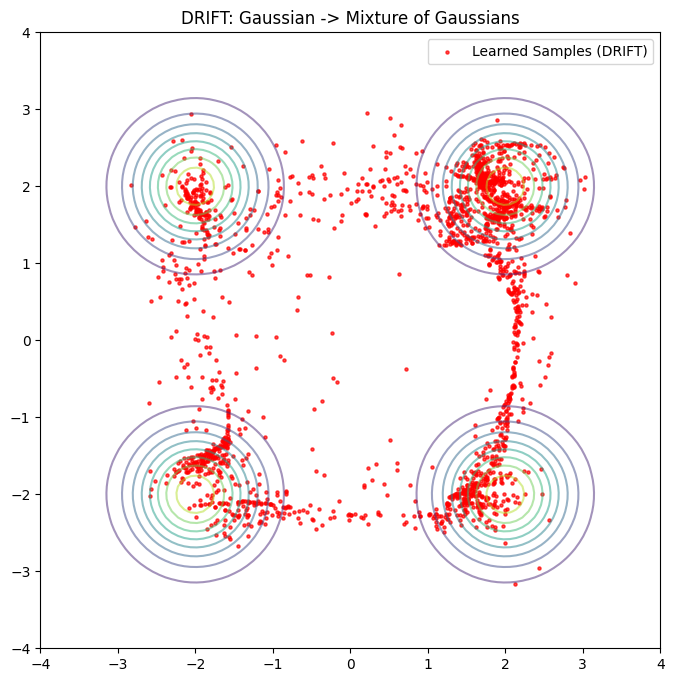

In [45]:
import jax
import jax.numpy as jnp
from jax.nn import initializers
from flax import linen as nn
from flax.training import train_state
import optax
import numpy as np
import matplotlib.pyplot as plt
from typing import Sequence, Callable, Tuple
from flax.core import FrozenDict # Import FrozenDict for type hinting

# --- 1. Target Distribution: Mixture of Gaussians ---
class MixtureOfGaussians:
    def __init__(self, means, covs, weights):
        self.means = jnp.array(means)  # (K, D)
        self.covs = jnp.array(covs)    # (K, D, D)
        self.weights = jnp.array(weights) # (K,)
        self.inv_covs = jnp.linalg.inv(self.covs)
        self.dets = jnp.linalg.det(self.covs)

    def log_prob(self, x):
        # x: (D,) or (N, D)
        if x.ndim == 1:
            x = x[None, :]

        diff = x[:, None, :] - self.means[None, :, :]

        def get_mahalanobis(d, inv_cov):
             return jnp.sum(d @ inv_cov * d, axis=-1)

        term = jax.vmap(get_mahalanobis, in_axes=(1, 0), out_axes=1)(diff, self.inv_covs)
        D = x.shape[1]
        log_coeffs = -0.5 * (D * jnp.log(2 * jnp.pi) + jnp.log(self.dets))
        log_p_k = log_coeffs[None, :] - 0.5 * term
        log_prob = jax.scipy.special.logsumexp(jnp.log(self.weights)[None, :] + log_p_k, axis=1)
        return log_prob.squeeze()

    def score(self, x):
        # grad of log_prob w.r.t x
        return jax.grad(lambda z: jnp.sum(self.log_prob(z)))(x)

# Define a 2D MoG
def make_target():
    means = [[-2.0, -2.0], [2.0, 2.0], [-2.0, 2.0], [2.0, -2.0]]
    covs = [np.eye(2) * 0.3 for _ in range(4)]
    weights = [0.25, 0.25, 0.25, 0.25]
    return MixtureOfGaussians(means, covs, weights)

# --- 2. Actor Network ---

class ResidualBlock(nn.Module):
    features: int

    @nn.compact
    def __call__(self, x):
        shortcut = x
        x = nn.Dense(features=self.features)(x)
        x = nn.relu(x)
        x = nn.Dense(features=self.features)(x)
        return x + shortcut

class Actor(nn.Module):
    output_dim: int
    hidden_dim: int = 64
    num_res_blocks: int = 2

    @nn.compact
    def __call__(self, z):
        x = nn.Dense(self.hidden_dim)(z)
        x = nn.relu(x) # Initial activation

        for _ in range(self.num_res_blocks):
            x = ResidualBlock(features=self.hidden_dim)(x)

        x = nn.Dense(self.output_dim, kernel_init=initializers.normal(stddev=1.2))(x)
        return x

# --- 3. DRIFT Logic (Adapted from drift.py) ---
def rbf_kernel(X_probe, X_batch, h):
    XX = (X_batch * X_batch).sum(1)
    XY = X_probe @ X_batch.T
    YY = (X_probe * X_probe).sum(1)
    sq_distances = XX[:, None] + YY[None, :] - 2 * XY
    sq_distances = jnp.maximum(sq_distances, 0.0)
    return jnp.exp(-sq_distances / h), sq_distances

def rbf_kernel_drift(X_probe, X_batch, h, kernal_weight):
    k_sum = jnp.sum(kernal_weight, axis=1, keepdims=True)
    drift = 2.0 / h * (k_sum*X_probe - kernal_weight @ X_batch)
    return drift

def get_stein_drift(obs, actions, score_fn, h_ratio=1.0):
    # 1. 计算距离和核函数
    XX = (actions * actions).sum(1)
    XY = actions @ actions.T
    sq_distances = XX[:, None] + XX[None, :] - 2 * XY
    sq_distances = jnp.maximum(sq_distances, 0.0)

    median_sq = jnp.median(sq_distances)
    # 带宽计算: 加上 max(0.5) 保底，防止 h 太小爆炸
    h = median_sq / jnp.log(actions.shape[0] + 1.0)
    h = jnp.maximum(h, 0.5)

    kernal = jnp.exp(-sq_distances / h)
    score = score_fn(actions)

    # 2. 计算力
    positive_drift = kernal @ score
    replusive_drift = rbf_kernel_drift(actions, actions, h, kernal_weight=kernal)

    # 3. 归一化 (关键一步)
    k_sum = jnp.sum(kernal, axis=1, keepdims=True) + 1e-6

    repulsion_weight = 1.0

    drift = (positive_drift + repulsion_weight * replusive_drift) / k_sum

    # Debug 打印 (观察平衡性)
    score_mag = jnp.mean(jnp.linalg.norm(positive_drift/k_sum, axis=1))
    rep_mag = jnp.mean(jnp.linalg.norm(replusive_drift/k_sum, axis=1))
    # jax.debug.print("Eff. Score: {} | Eff. Rep (x10): {}", score_mag, rep_mag * repulsion_weight)

    return drift

# --- 4. Training Loop ---
# Define a custom TrainState for Polyak averaging
class ActorTrainState(train_state.TrainState):
    target_params: FrozenDict # Use FrozenDict for type hinting

def run_drift_experiment(key, num_samples=2000, num_training_steps=1000, batch_size=1024, lr=1e-3, tau=0.005):
    target_dist = make_target()

    actor = Actor(output_dim=2)
    key, subkey = jax.random.split(key)
    dummy_z = jax.random.normal(subkey, (10, 2)) # Latent dim 2
    params = actor.init(subkey, dummy_z)

    tx = optax.adam(learning_rate=lr)
    state = ActorTrainState.create(
        apply_fn=actor.apply,
        params=params,
        tx=tx,
        target_params=params # Initialize target_params with the same values
    )

    @jax.jit
    def train_step(state: ActorTrainState, key):
        z_key, subkey = jax.random.split(key)
        z = jax.random.normal(z_key, (batch_size, 2)) * 2.0

        def loss_fn(params):
            gen = state.apply_fn(params, z)
            drift = get_stein_drift(None, gen, target_dist.score)
            drift_step = 1.0
            target = gen + drift_step * drift

            # MSE Loss
            return jnp.mean(jnp.sum((gen - jax.lax.stop_gradient(target))**2, axis=1))

        loss, grads = jax.value_and_grad(loss_fn)(state.params)
        state = state.apply_gradients(grads=grads)

        return state, loss

    print("Running DRIFT training...")
    losses = []
    for i in range(num_training_steps):
        key, subkey = jax.random.split(key)
        state, loss = train_step(state, subkey)
        losses.append(loss)
        if i % 200 == 0:
            print(f"  Step {i}, Loss: {loss:.4f}")

    key, subkey = jax.random.split(key)
    z_vis = jax.random.normal(subkey, (num_samples, 2))
    samples = state.apply_fn(state.params, z_vis) # Use state.params for final samples
    return samples, target_dist


key = jax.random.PRNGKey(77)
samples, target_dist = run_drift_experiment(key)

print("Plotting DRIFT results...")

x = np.linspace(-4, 4, 100)
y = np.linspace(-4, 4, 100)
X, Y = np.meshgrid(x, y)
grid = np.stack([X.ravel(), Y.ravel()], axis=1)
log_probs = target_dist.log_prob(grid).reshape(100, 100)

plt.figure(figsize=(8, 8))
plt.contour(X, Y, jnp.exp(log_probs), levels=10, cmap='viridis', alpha=0.5)
plt.scatter(samples[:, 0], samples[:, 1], s=5, c='red', alpha=0.7, label='Learned Samples (DRIFT)')
plt.title("DRIFT: Gaussian -> Mixture of Gaussians")
plt.legend()
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.savefig('drift_mog_demo.png')
print("Saved plot to drift_mog_demo.png")